In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,davies_bouldin_score,precision_recall_fscore_support
import numpy as np

In [81]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

### Find optimal n_components

In [45]:
def get_gmms():
    gmms = {n:mixture.GaussianMixture(n_components=n,covariance_type='full') for n in range(2,15)}
    [gmm.fit(train) for gmm in gmms.values()]
    return gmms

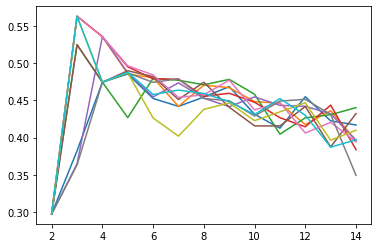

In [46]:
for _ in range(10):
    gmms = get_gmms()
    plotdata = {n: silhouette_score(train,v.predict(train)) for (n,v) in gmms.items()}
    plt.plot(plotdata.keys(),plotdata.values())
# silhouette score vs n_components

It looks like there are either three or four components

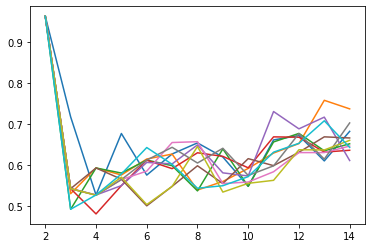

In [49]:
for _ in range(10):
    gmms = get_gmms()
    plotdata = {n: davies_bouldin_score(train,v.predict(train)) for (n,v) in gmms.items()}
    plt.plot(plotdata.keys(),plotdata.values())
# davies bouldin score vs n_components

With the two graphs combined, it looks like using n=2 is optimal

## Sample log probabilities

In [53]:
gmm = mixture.GaussianMixture(n_components=2,covariance_type='full', random_state=0)
gmm.fit(train)

GaussianMixture(n_components=2, random_state=0)

<AxesSubplot:ylabel='Count'>

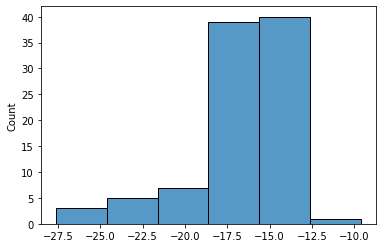

In [71]:
trainscore = gmm.score_samples(train)
sns.histplot(trainscore,binwidth=3)
# log probability of data

In [58]:
min(trainscore)

-27.618390082374155

<AxesSubplot:ylabel='Count'>

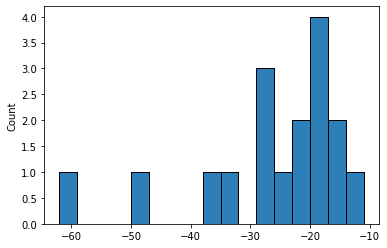

In [66]:
valscore = gmm.score_samples(val)
sns.histplot(valscore,binwidth=3)
# log probability of validation data

It looks like -30 is a reasonable threshold, as it does not cut off any non-outlier data

In [157]:
threshold = -30

Let's graph train and val on a pca graph

In [94]:
pca = PCA(n_components=2)
pca.fit(train)
pca_train = pca.transform(train)
pca_val = pca.transform(val)
# for a future graph
pca_test = pca.transform(test[test.columns[1:]])


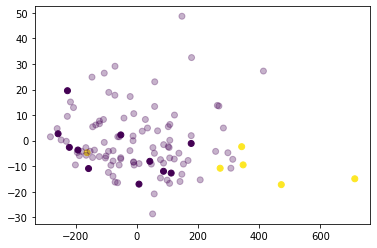

In [119]:
plt.scatter(pca_val[:,0],pca_val[:,1],c=gmm.score_samples(val)<threshold)
plt.scatter(pca_train[:,0],pca_train[:,1],c=gmm.score_samples(train)<threshold,alpha=0.3)
# translucent - train set, solid - validation set

Let's see how the model does on the test set

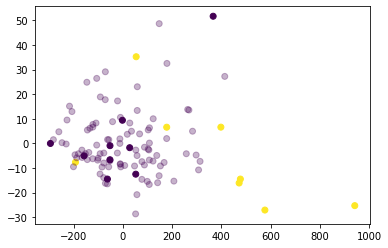

In [120]:
plt.scatter(pca_test[:,0],pca_test[:,1],c=gmm.score_samples(test[test.columns[1:]])<threshold)
plt.scatter(pca_train[:,0],pca_train[:,1],c=gmm.score_samples(train)<threshold,alpha=0.3)

In [159]:
y_true = (np.array(test['class'] == 1)).astype(int)
y_pred = (gmm.score_samples(test[test.columns[1:]])<threshold).astype(int)
scores = [[*precision_recall_fscore_support(y_true,y_pred,average = avg)][:-1] for avg in ['micro','macro','weighted']] 

In [160]:
pd.DataFrame(scores,columns=['Precision','Recall','FScore'],index=['micro','macro','weighted'])

,Precision,Recall,FScore
micro,0.941176,0.941176,0.941176
macro,0.916667,0.958333,0.932806
weighted,0.950980,0.941176,0.942571
